<a href="https://colab.research.google.com/github/Ersel26/echo_KVAK/blob/main/echo_KVAK_efficientNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import os
import cv2
import random
from keras.preprocessing.image import ImageDataGenerator
from keras import layers
from keras.optimizers import Adam
from keras.applications import EfficientNetB3
from keras.applications import EfficientNetB0
from keras.models import Sequential

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
DIRECTORY = r"/content/drive/MyDrive/Echo_KVAK/labeled data"
IMG_SIZE = 224 # for EffectiveNetB0
BATCH_SIZE = 32
NUM_CLASSES = len(os.listdir(DIRECTORY))

In [ ]:
def create_data_ImageDataGenerator(data_gen, data_dir):
  train_generator = data_gen.flow_from_directory(
    data_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    color_mode='grayscale',
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=True,
    subset='training'
  ) 
  validation_generator = data_gen.flow_from_directory(
    data_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    color_mode='grayscale',
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=True,
    subset='validation')  # set as validation data
  return (train_generator, validation_generator)

In [ ]:
data_gen = ImageDataGenerator(
        # rotation_range=40,
        # width_shift_range=0.2,
        # height_shift_range=0.2,
        rotation_range=0,
        width_shift_range=0,
        height_shift_range=0,
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        vertical_flip=True,
        fill_mode='nearest',
        validation_split=0.2)

(train_generator, validation_generator) = create_data_ImageDataGenerator(data_gen, DIRECTORY)

Found 9209 images belonging to 7 classes.
Found 2300 images belonging to 7 classes.


#EfficientNETB0 with initial weights and w/o data augmentation

In [ ]:
efficient_net = EfficientNetB0(
    weights="imagenet",
    input_shape=(IMG_SIZE,IMG_SIZE,3),
    include_top=False,
    pooling='max'
)

model = tf.keras.models.Sequential()
model.add(efficient_net)
model.add(layers.Dense(units = 120, activation='relu'))
model.add(layers.Dense(units = 120, activation = 'relu'))
model.add(layers.Dense(units = NUM_CLASSES, activation='sigmoid'))
model.summary()

model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"] )

In [ ]:
history = model.fit(
    train_generator, 
    epochs = 30,
    validation_data = validation_generator, 
    verbose = 1,
    steps_per_epoch = 288,
    validation_steps = 7,
    )

In [ ]:
loss_train = history.history['loss']
loss_val = history.history['val_loss']
epochs = range(0,30)
plt.plot(epochs, loss_train, 'g', label='Training loss')
plt.plot(epochs, loss_val, 'b', label='validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
loss_train = history.history['accuracy']
loss_val = history.history['val_accuracy']
epochs = range(0,30)
plt.plot(epochs, loss_train, 'g', label='Training acc')
plt.plot(epochs, loss_val, 'b', label='validation acc')
plt.title('Training and Validation acc')
plt.xlabel('Epochs')
plt.ylabel('acc')
plt.legend()
plt.show()

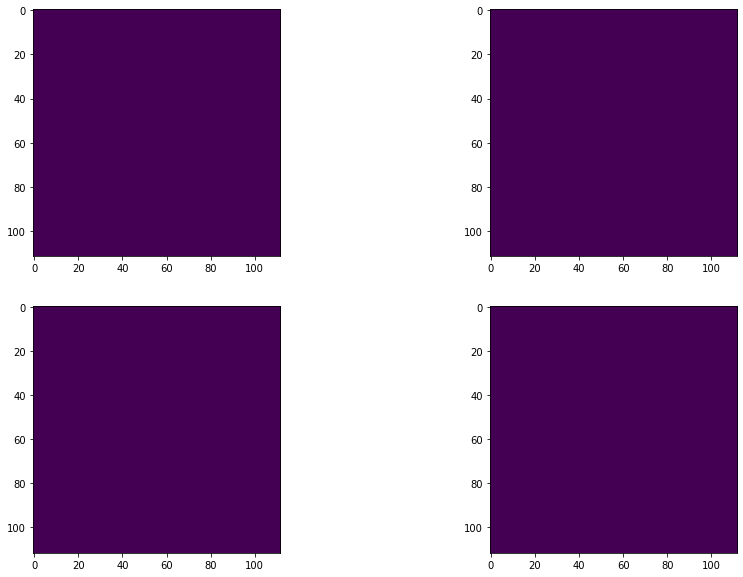

In [ ]:
rows = 2
columns = 2
fig, axes = plt.subplots(rows,columns)
for r in range(rows):
    for c in range(columns):
        image_batch = train_generator.next()[0]
        image = image_batch[0].astype('uint8')*255
        axes[r,c].imshow(image)
fig.set_size_inches(15,10)

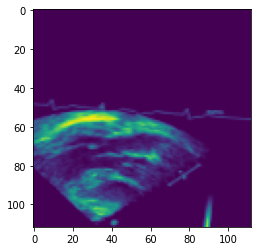

In [ ]:
train_images, train_labels = next(train_generator)
plt.imshow(train_images[15])

In [ ]:
efficient_net = EfficientNetB3(
    weights=None,
    input_shape=(IMG_SIZE,IMG_SIZE,1),
    include_top=False,
    pooling='max'
)

model = tf.keras.models.Sequential()
model.add(efficient_net)
model.add(layers.Dense(units = 120, activation='relu'))
model.add(layers.Dense(units = 120, activation = 'relu'))
model.add(layers.Dense(units = NUM_CLASSES, activation='sigmoid'))
model.summary()

model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"] )

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb3 (Functional)  (None, 1536)             10782811  
                                                                 
 dense (Dense)               (None, 120)               184440    
                                                                 
 dense_1 (Dense)             (None, 120)               14520     
                                                                 
 dense_2 (Dense)             (None, 7)                 847       
                                                                 
Total params: 10,982,618
Trainable params: 10,895,319
Non-trainable params: 87,299
_________________________________________________________________


In [ ]:
#callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)

history = model.fit(
    train_generator,
    epochs = 50,
    steps_per_epoch = 15,
    validation_data = validation_generator,
    validation_steps = 7
)

Epoch 1/50
15/15 [==============================] - 98s 7s/step - loss: 1.7541 - accuracy: 0.2896 - val_loss: 1.7709 - val_accuracy: 0.2768
Epoch 2/50
15/15 [==============================] - 90s 6s/step - loss: 1.7880 - accuracy: 0.2771 - val_loss: 1.8150 - val_accuracy: 0.2545
Epoch 3/50
15/15 [==============================] - 76s 5s/step - loss: 1.7600 - accuracy: 0.2704 - val_loss: 1.7723 - val_accuracy: 0.2500
Epoch 4/50
15/15 [==============================] - 76s 5s/step - loss: 1.7735 - accuracy: 0.2896 - val_loss: 1.7473 - val_accuracy: 0.2946
Epoch 5/50
15/15 [==============================] - 66s 4s/step - loss: 1.7521 - accuracy: 0.3250 - val_loss: 1.7684 - val_accuracy: 0.2723
Epoch 6/50
15/15 [==============================] - 69s 5s/step - loss: 1.7585 - accuracy: 0.3000 - val_loss: 1.8315 - val_accuracy: 0.2366
Epoch 7/50
15/15 [==============================] - 57s 4s/step - loss: 1.7782 - accuracy: 0.2875 - val_loss: 1.7869 - val_accuracy: 0.2277
Epoch 8/50
15/15 [==

In [ ]:
print(history.history.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


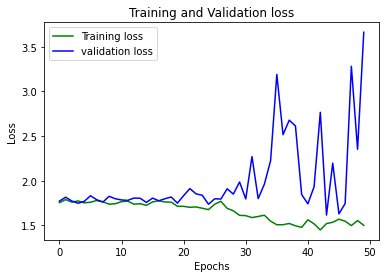

In [ ]:
loss_train = history.history['loss']
loss_val = history.history['val_loss']
epochs = range(0,50)
plt.plot(epochs, loss_train, 'g', label='Training loss')
plt.plot(epochs, loss_val, 'b', label='validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

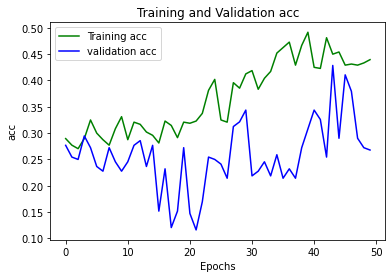

In [ ]:
loss_train = history.history['accuracy']
loss_val = history.history['val_accuracy']
epochs = range(0,50)
plt.plot(epochs, loss_train, 'g', label='Training acc')
plt.plot(epochs, loss_val, 'b', label='validation acc')
plt.title('Training and Validation acc')
plt.xlabel('Epochs')
plt.ylabel('acc')
plt.legend()
plt.show()